Lateness Report [link](https://gttwiki.atlassian.net/wiki/spaces/GD/pages/2492956684/Lateness+report)

Approach for segmentation (compare time regained after going through a segment for TSPon vs TSPoff)

WARNING: here it is considered that stopindex is a unique identifier of a stop for given routename+direction. Still, it is not true and another udentifier shoul be used later

In [1]:
import pandas as pd
import os
from data_preparation import prepare_triplogs, prepare_tripdatas, get_clean_triplogs, get_clean_tripdatas

In [2]:
data_dir = "../2020_11_8_to_2020_11_14"

In [3]:
!ls ../2020_11_8_to_2020_11_14/CMS

intersectionstatusreport.csv
intersectionstatusreport_data_dictionary.docx
opticomdevicelog.csv
opticomdevicelog_data_dictonary.docx


In [4]:
tripdatas_df = pd.read_csv(os.path.join(data_dir, "CVP/tripdatas.csv"))

In [5]:
triplogs_df = pd.read_csv(os.path.join(data_dir, "CVP/triplogs.csv"))

In [42]:
from collections import defaultdict
triplogs_df = prepare_triplogs(triplogs_df)
tripdatas_df = prepare_tripdatas(tripdatas_df)

# takes about 10 minutes to run

filtration_dict=defaultdict(lambda: True)
filtration_dict["tspmode_not_normal_test"] = False

tripdatas_df = get_clean_tripdatas(tripdatas_df) # cleaning tripdatas first is important
tripdatas_df_good = tripdatas_df[tripdatas_df["is_good_for_study"]]
triplogs_df = get_clean_triplogs(triplogs_df, tripdatas_df_good, filtration_dict)
triplogs_df_good = triplogs_df[triplogs_df["is_good_for_study"]]

drop invalid
drop starttime >= endtime
drop endstatus not completed
drop negative duration
drop <=70% stops hit
drop <=70% breadcrumbs
drop duplicated rows
drop 3 stds anomalies


In [52]:
triplogs_df_raw = pd.read_csv(os.path.join(data_dir, "CVP/triplogs.csv"))

In [75]:
from collections import defaultdict

def get_uid_to_curbreadcrumbs(tripdatas_df_good):
    uid_to_curbreadcrumbs = defaultdict(list)
    for ind, row in tripdatas_df_good[tripdatas_df_good["event"].isin(['stop arrive','stop depart'])].sort_values("time").iterrows():
        uid_to_curbreadcrumbs[row["uid"]].append(row)

    for k in uid_to_curbreadcrumbs.keys():
        uid_to_curbreadcrumbs[k] = pd.DataFrame(uid_to_curbreadcrumbs[k])
    return uid_to_curbreadcrumbs
        


In [166]:
tripdatas_df_good.columns

Index(['__v', '_id', 'deviceid', 'dir', 'distance', 'dwelltime', 'emitterid',
       'event', 'headway', 'loc', 'logid', 'mph', 'routename', 'stopindex',
       'stopname', 'time', 'tracktime', 'traveltime', 'unloc', 'date_ran',
       'uid', 'reason_not_good_for_study', 'is_good_for_study'],
      dtype='object')

In [76]:
uid_to_curbreadcrumbs = get_uid_to_curbreadcrumbs(tripdatas_df_good)

In [170]:
def get_segment_regains(triplog_row, uid_to_curbreadcrumbs):
    """
    triplog_row - row from triplogs
    uid_to_curbreadcrumbs - dict with keys - uids and values - dfs with breadcrumbs event == stop arrive or stop depart
    """
    segment_to_regain = {}
    
    triplog_uid = triplog_row["uid"]
    routename = triplog_row["routename"]
    direction = triplog_row["direction"]
    
    curbreadcrumbs_df = uid_to_curbreadcrumbs[triplog_uid]
    
    cur_len = len(curbreadcrumbs_df)
    for ind, val in enumerate(curbreadcrumbs_df.iterrows()):
        row = val[1]
        if ind + 1 < cur_len and row["event"] == "stop depart" and curbreadcrumbs_df.iloc[ind + 1]["event"] == "stop arrive":
            
            before_seg_tracktime = row["tracktime"]
            after_seg_tracktime = curbreadcrumbs_df.iloc[ind + 1]["tracktime"]
            regain = after_seg_tracktime - before_seg_tracktime
            segment_to_regain[str(row['stopname']) + "_" + str(curbreadcrumbs_df.iloc[ind + 1]['stopname'])] = regain
        
    return segment_to_regain

In [171]:
triplogs_df_good["segment_regains"] = triplogs_df_good.apply(lambda row: get_segment_regains(row, uid_to_curbreadcrumbs) , axis = 1)

/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [172]:
triplogs_df_good["segment_regains"].head()

1    {'Alemany Blvd & St Charles Ave_Alemany Blvd &...
3    {'North Point St & Stockton St_Powell St & Nor...
4    {'Haight St & Clayton St_Cole St & Haight St:'...
5    {'South Hill Blvd & Rolph St:_South Hill Blvd ...
8    {'D.C. Bart Parking Lot E_Daly City Bart Stati...
Name: segment_regains, dtype: object

In [173]:
routename_direction_segments_to_regains_alwayson = defaultdict(list)

for ind, row in triplogs_df_good[triplogs_df_good['tspmode'] == "alwaysOn"].iterrows():
    seg_regains = row["segment_regains"]
    for seg in seg_regains.keys():
        routename_direction_segments_to_regains_alwayson[row["routename"] + "_" + row["direction"] + "_" + seg].append(seg_regains[seg])
        

routename_direction_segments_to_regains_alwaysoff = defaultdict(list)

for ind, row in triplogs_df_good[triplogs_df_good['tspmode'] == "alwaysOff"].iterrows():
    seg_regains = row["segment_regains"]
    for seg in seg_regains.keys():
        routename_direction_segments_to_regains_alwaysoff[row["routename"] + "_" + row["direction"] + "_" + seg].append(seg_regains[seg])

        

In [174]:
from scipy import stats
# mann-whitney u-test
def mannwhitney(triplogs_on_dict, triplogs_off_dict):
    rejected = []
    num_errors = 0
    for seg in triplogs_on_dict.keys():
        if seg in triplogs_off_dict.keys():
            try:
                pval = stats.mannwhitneyu(triplogs_on_dict[seg], triplogs_off_dict[seg], alternative='greater').pvalue
                if pval < 0.05:
                    pass
                    #print(idx, f'route is significally faster with pval {pval:.2f}')
                rejected.append(
                    (pval, seg)
                )
            except ValueError:
                num_errors += 1
            
    print(len(rejected), 'of', len(triplogs_on_dict), 'rejected', len(rejected)/len(triplogs_on_dict))
    return rejected, num_errors

In [175]:
# student two samples t-test
import numpy as np
def student(triplogs_on_dict, triplogs_off_dict):
    rejected = []
    num_errors = 0
    for seg in triplogs_on.keys():
        if seg in triplogs_off.keys():   
            pval = stats.ttest_ind(triplogs_on_dict[seg], triplogs_off_dict[seg], alternative='greater').pvalue
            if pval < 0.05:
                # check same variance assumption (timings of two type of routes must have variance close to each other)
                s1 = np.sqrt(np.var(triplogs_on_dict[seg], ddof=1))
                s2 = np.sqrt(np.var(triplogs_off_dict[seg], ddof=1))
                valid = 'test valid'
                if np.abs(s1 - s2) > 3:
                    num_errors += 1
                else:
                    rejected.append(
                        (pval, seg)
                    )
    print(len(rejected), 'of', len(triplogs_on_dict), 'rejected', len(rejected)/len(triplogs_on_dict))
    return rejected, num_errors

In [176]:
def plot_trips(triplogs_on_dict, triplogs_off_dict, rejected):
    fig, ax = plt.subplots(len(rejected), 1,figsize=(15,15), constrained_layout=True)
    for i, (pval, seg)  in enumerate(rejected):
        title = f'{str(seg)}, pval {pval:.2f}'
        ax[i].set_title(title)
        ax[i].plot(triplogs_on_dict[seg], label='on')
        ax[i].plot(triplogs_off_dict[seg], label='off')
        ax[i].legend()

In [177]:
triplogs_on = routename_direction_segments_to_regains_alwayson
triplogs_off = routename_direction_segments_to_regains_alwaysoff

2975 of 3625 rejected 0.8206896551724138
number of errors: 95


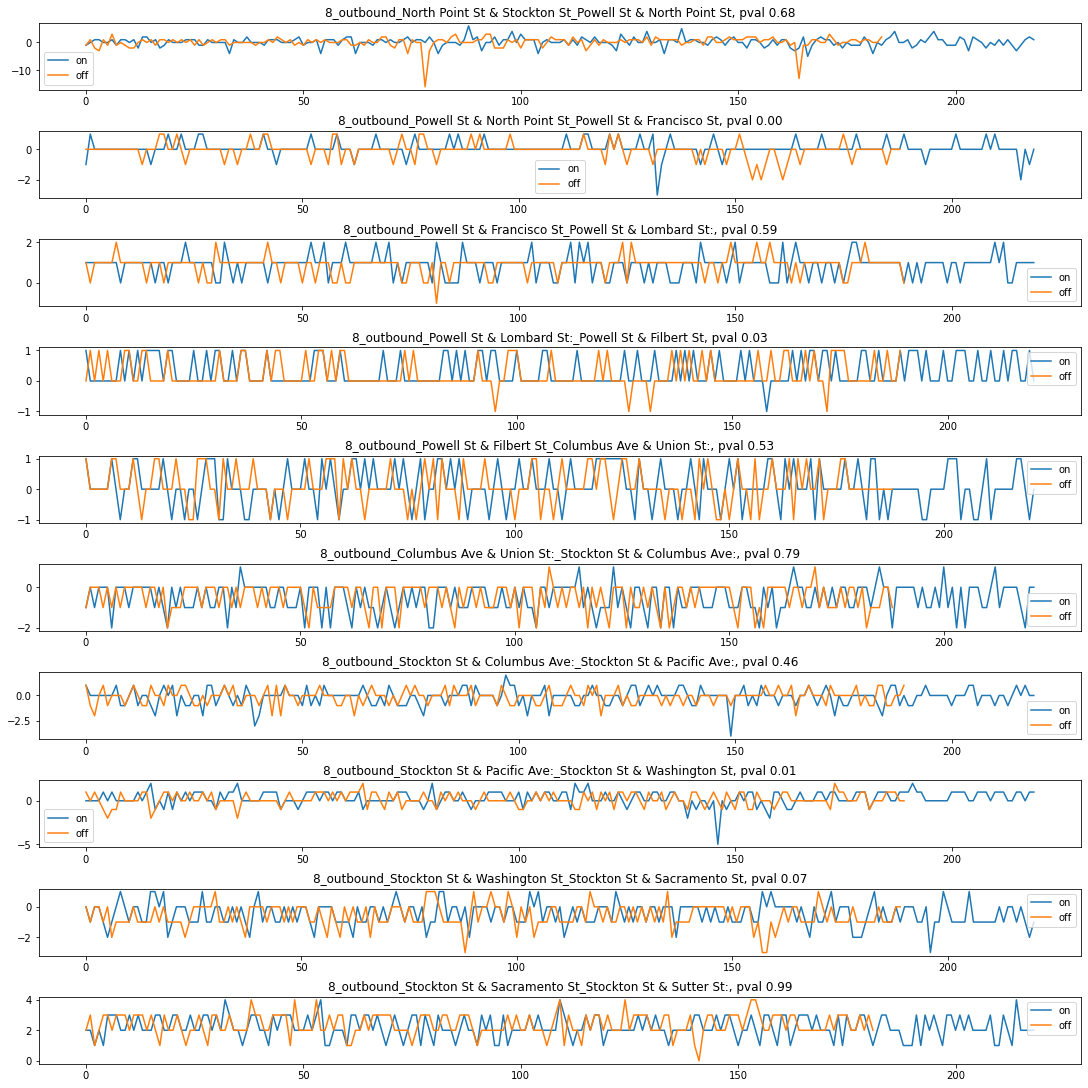

In [178]:
import matplotlib.pyplot as plt
rejected_segs_manw, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_segs_manw[:10])

/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


154 of 3625 rejected 0.042482758620689655
number of errors: 2


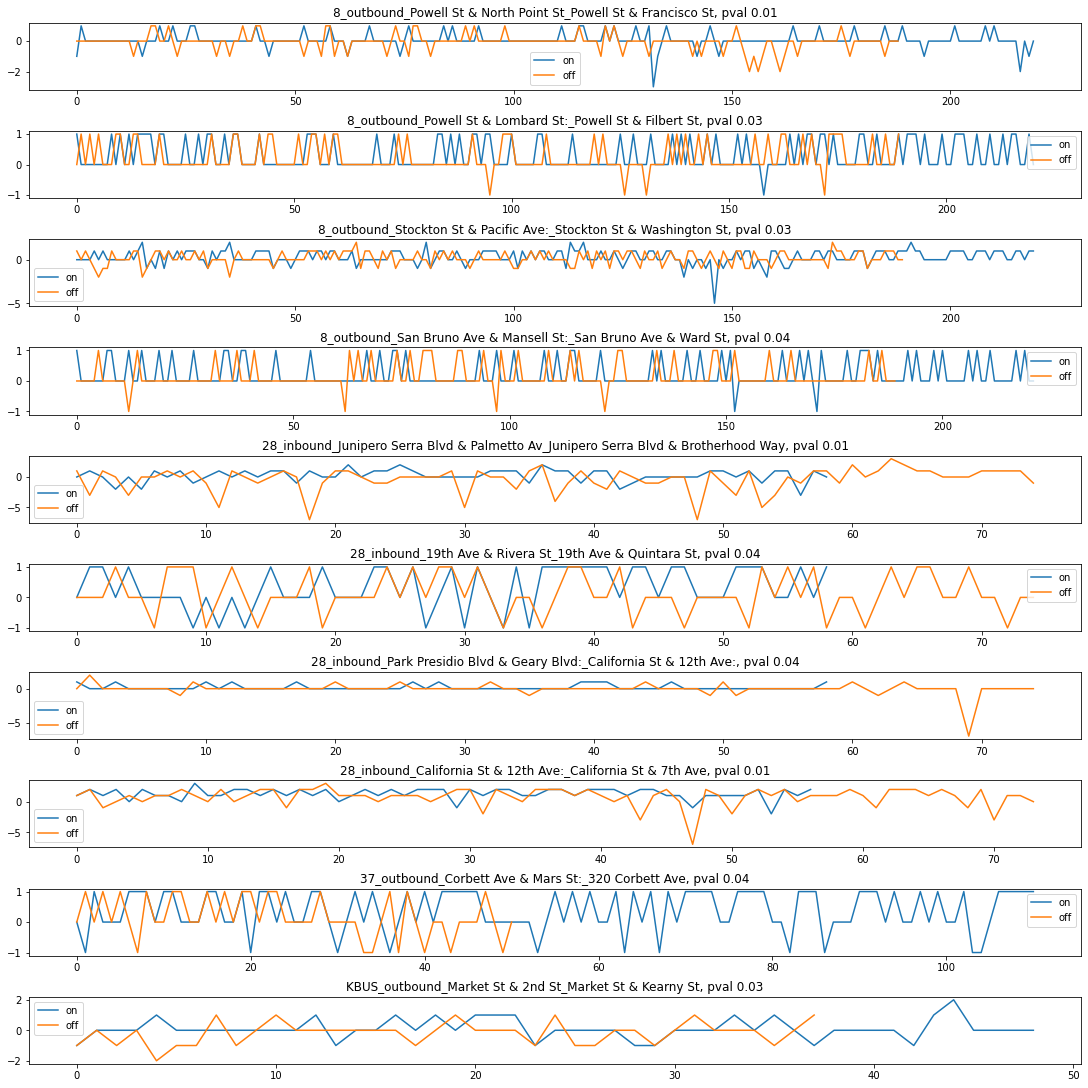

In [179]:
rejected_segs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_segs_stud[:10])

In [180]:
rejected_idxs_manw_new = [x[1] for x in rejected_segs_manw]
rejected_idxs_stud_new = [x[1] for x in rejected_segs_stud]
len(set(rejected_idxs_manw_new).intersection(rejected_idxs_stud_new))

154

## Hourly separation

In [181]:
def get_segment_regains_hourly(triplog_row, uid_to_curbreadcrumbs):
    """
    triplog_row - row from triplogs
    uid_to_curbreadcrumbs - dict with keys - uids and values - dfs with breadcrumbs event == stop arrive or stop depart
    """
    segment_to_regain = {}
    
    triplog_uid = triplog_row["uid"]
    routename = triplog_row["routename"]
    direction = triplog_row["direction"]
    
    curbreadcrumbs_df = uid_to_curbreadcrumbs[triplog_uid]
    
    cur_len = len(curbreadcrumbs_df)
    for ind, val in enumerate(curbreadcrumbs_df.iterrows()):
        row = val[1]
        if ind + 1 < cur_len and row["event"] == "stop depart" and curbreadcrumbs_df.iloc[ind + 1]["event"] == "stop arrive":
            
            before_seg_tracktime = row["tracktime"]
            after_seg_tracktime = curbreadcrumbs_df.iloc[ind + 1]["tracktime"]
            regain = after_seg_tracktime - before_seg_tracktime
            segment_to_regain[str(row['stopname']) + "_" + str(curbreadcrumbs_df.iloc[ind + 1]['stopname']) + "_hour:_" + str(row["time"].hour)] = regain
        
    return segment_to_regain

In [182]:
triplogs_df_good["segment_regains_hourly"] = triplogs_df_good.apply(lambda row: get_segment_regains_hourly(row, uid_to_curbreadcrumbs) , axis = 1)

/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [183]:
triplogs_df_good["segment_regains_hourly"].head()

1    {'Alemany Blvd & St Charles Ave_Alemany Blvd &...
3    {'North Point St & Stockton St_Powell St & Nor...
4    {'Haight St & Clayton St_Cole St & Haight St:_...
5    {'South Hill Blvd & Rolph St:_South Hill Blvd ...
8    {'D.C. Bart Parking Lot E_Daly City Bart Stati...
Name: segment_regains_hourly, dtype: object

In [189]:
routename_direction_segments_to_regains_alwayson = defaultdict(list)

for ind, row in triplogs_df_good[triplogs_df_good['tspmode'] == "alwaysOn"].iterrows():
    seg_regains = row["segment_regains_hourly"]
    for seg in seg_regains.keys():
        routename_direction_segments_to_regains_alwayson[row["routename"] + "_" + row["direction"] + "_" + seg].append(seg_regains[seg])
        

routename_direction_segments_to_regains_alwaysoff = defaultdict(list)

for ind, row in triplogs_df_good[triplogs_df_good['tspmode'] == "alwaysOff"].iterrows():
    seg_regains = row["segment_regains_hourly"]
    for seg in seg_regains.keys():
        routename_direction_segments_to_regains_alwaysoff[row["routename"] + "_" + row["direction"] + "_" + seg].append(seg_regains[seg])


In [190]:
triplogs_on = routename_direction_segments_to_regains_alwayson
triplogs_off = routename_direction_segments_to_regains_alwaysoff

28887 of 38021 rejected 0.7597643407590542
number of errors: 3132


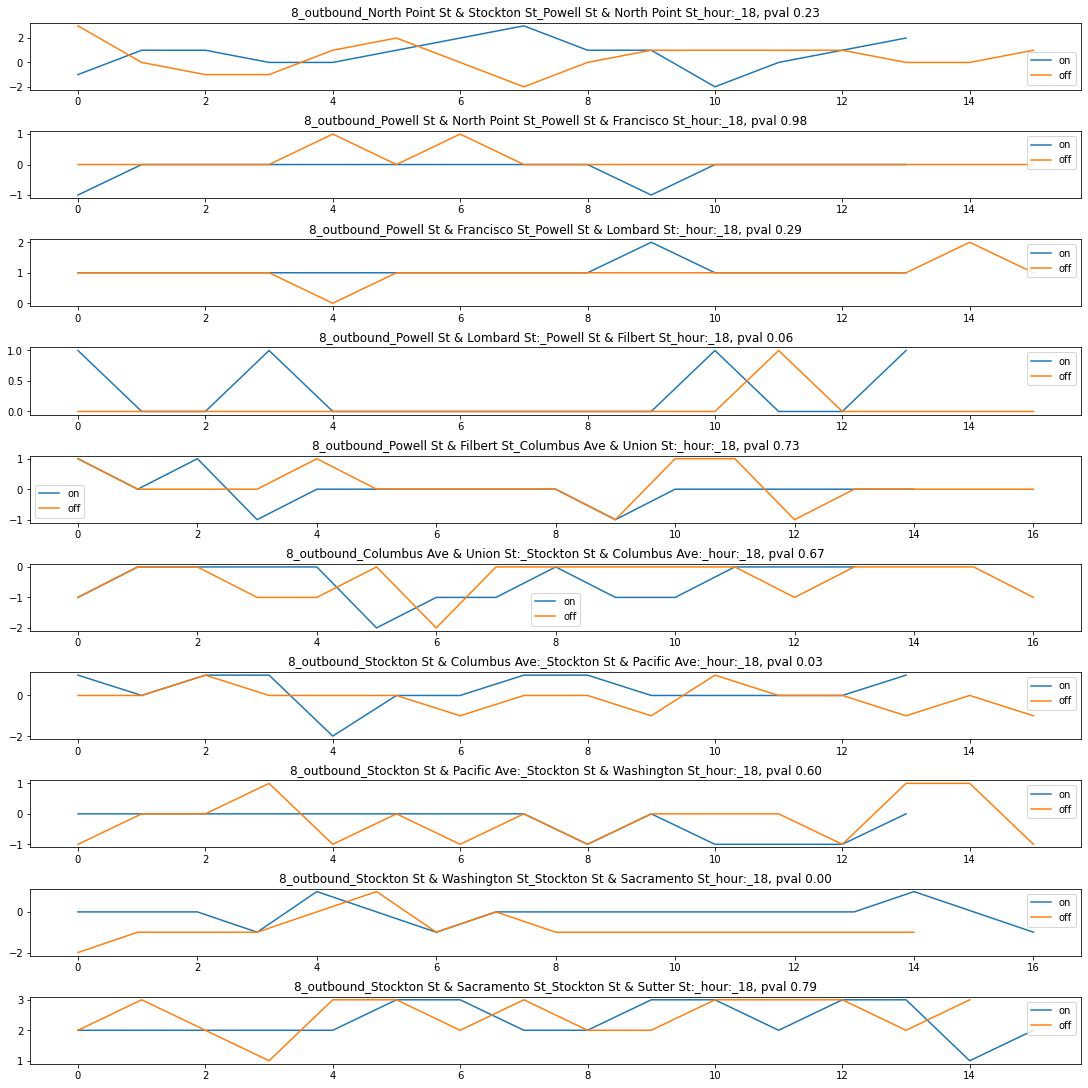

In [191]:
import matplotlib.pyplot as plt
rejected_segs_manw, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_segs_manw[:10])

1048 of 38021 rejected 0.027563714789195445
number of errors: 4


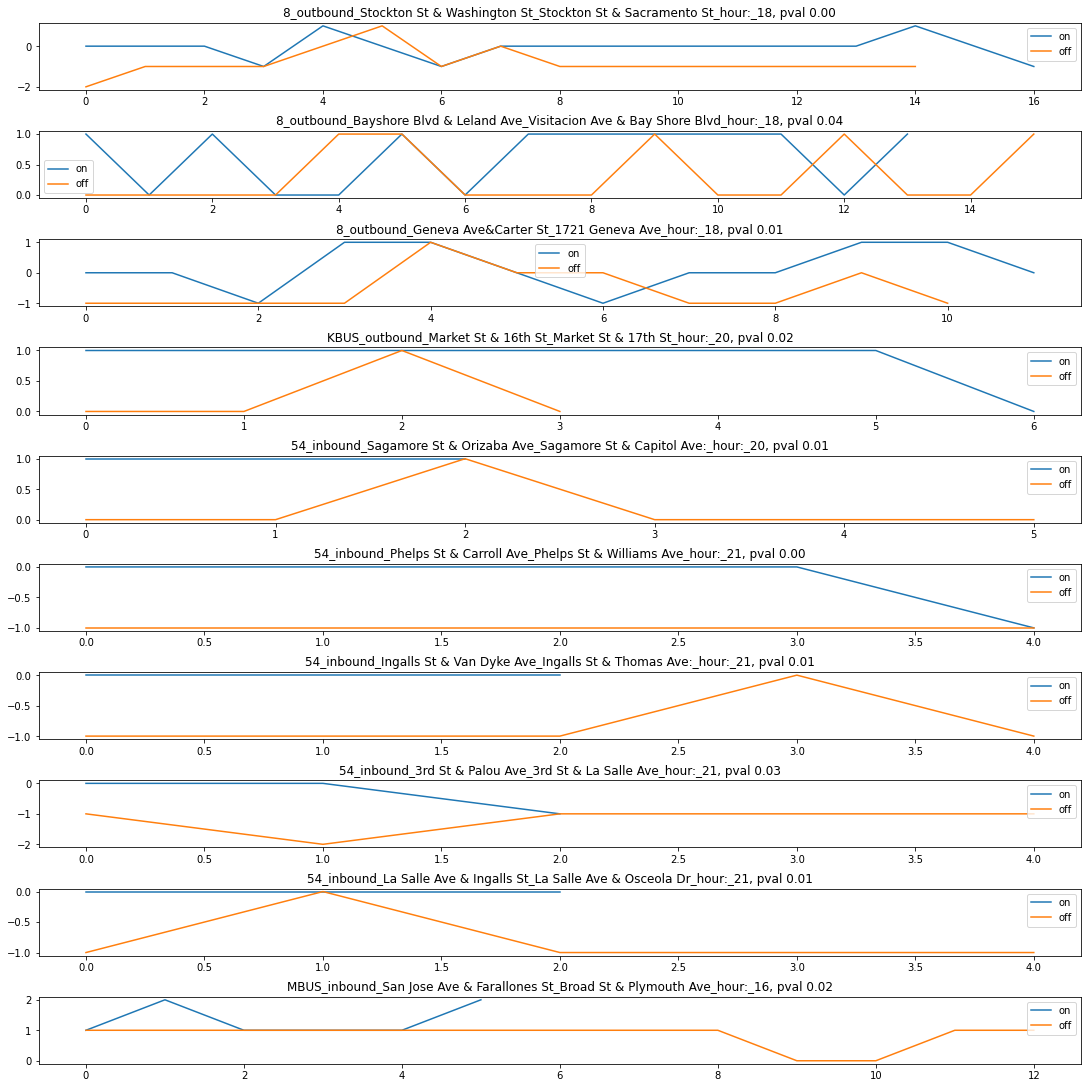

In [192]:
rejected_segs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_segs_stud[:10])

In [193]:
rejected_idxs_manw_new = [x[1] for x in rejected_segs_manw]
rejected_idxs_stud_new = [x[1] for x in rejected_segs_stud]
len(set(rejected_idxs_manw_new).intersection(rejected_idxs_stud_new))

1048